In [14]:
from PIL import Image 
import numpy as np
import matplotlib.pyplot as plt
import cv2

In [134]:
# DEFINING CONSTANTS

# Baseketball court image
test_img = np.asarray(Image.open('basketball-court.ppm'))
print(test_img.shape)

# Pixels chosen for the src & destination
in_pxs = np.array([[23, 193], [279, 279], [402, 74], [247, 51]])
out_pxs = np.array([[0, 940], [500, 940], [500, 0], [0, 0]])

# Bottom Left: (23, 193)   ->     (940, 0)
# Bottom Right: (279, 279) ->     (940, 500)
# Top Right: (402, 74)     ->     (0, 500)
# Top Left: (247, 51)      ->     (0, 0)

# Vector representations of each pixel
blv = np.append(in_pxs[0], 1)
brv = np.append(in_pxs[1], 1)
trv = np.append(in_pxs[2], 1)
tlv = np.append(in_pxs[3], 1)

blvp = np.append(out_pxs[0], 1)
brvp = np.append(out_pxs[1], 1)
trvp = np.append(out_pxs[2], 1)
tlvp = np.append(out_pxs[3], 1)

norm_cross = lambda v1, v2: np.cross(v1, v2) / np.cross(v1, v2)[-1] 

# Calculating source lines
in_l = np.array([norm_cross(blv, brv), norm_cross(tlv, trv),
                 norm_cross(blv, tlv), norm_cross(brv, trv)])

# Calculating destination lines (manually divided b/c lines are vertical)
out_l = np.array([np.cross(blvp, brvp) / -470000, np.cross(tlvp, trvp) / 500,
                 np.cross(blvp, tlvp) / 940, np.cross(brvp, trvp) / -470000])

(366, 488, 3)
[[ 0.0018132  -0.00539743  1.        ]
 [ 0.01034173 -0.06969424  1.        ]
 [-0.00305389 -0.00481741  1.        ]
 [-0.00224014 -0.00134409  1.        ]]
[[-0.         -0.00106383  1.        ]
 [ 0.          1.          0.        ]
 [ 1.          0.          0.        ]
 [-0.002      -0.          1.        ]]


In [176]:
class DLT_px_est:
    def __init__(self, in_pxs, out_pxs, img):
        '''
        Init for defining constants necessary during estimation
        '''
        assert in_pxs.shape == out_pxs.shape

        # Pxs chosen from original image & their mappings
        self.in_pxs = in_pxs
        self.out_pxs = out_pxs
        self.A = np.zeros((8, 9))

        # Dummy variable for Homography
        self.H = None
        self.H_inv = None

        # Dummy variable for Normalization Matrix (src & dest)
        self.T = None
        self.Tp = None
        self.T_inv = None
        self.Tp_inv = None

        # Number of rows / cols in dest image
        self.rows = 940
        self.cols = 500

        # Cords of pxs in destination image
        self.dest = np.asarray([[[j, i] for j in range(self.cols)] for i in range(self.rows)]).astype('float32')
        
        # Original Image
        self.orig = img

        # Placeholder for destination image
        self.new_img = np.zeros((self.rows, self.cols, 3)).astype('uint8')

    def construct_Ai(self, i):
        '''
        Given index for pair of pixels (src, dest), construct linear constraints Ai
        '''
        x, y, w = self.in_pxs[i][0], self.in_pxs[i][1], self.in_pxs[i][2]
        xp, yp, wp = self.out_pxs[i][0], self.out_pxs[i][1], self.in_pxs[i][2]

        system = np.array([
            [0, 0, 0, -x * wp, -y * wp, -w * wp, x * yp, y * yp, w * yp],
            [x * wp, y * wp, w * wp, 0, 0, 0, -x * xp, -y * xp, -w * xp]
        ])

        print(f'Assembled A{i} for {self.in_pxs[i]}')
        return system
    
    def assemble_A(self):
        '''
        Assemble A given each Ai
        '''
        self.Ap = []

        for i in range(len(self.in_pxs)):
            Ap = self.construct_Ai(i)
            self.A[i*2:(i+1)*2, :] = Ap
        
        print("Assembled A")

    def calc_SVD(self):
        '''
        Calculate Homography based on linear constraints A using SVD

        Returns normalized Homography
        '''

        # Get SVD
        U, S, V = np.linalg.svd(self.A, full_matrices=True)
        homography = V[-1].reshape((3,3))
        
        # Normalize last element to be 1
        return homography / homography[2,2]

    def calc_homography(self):
        '''
        Call all steps necessary to compute Homography
        1. assemble_A --> Get linear constraints matrix
        2. Calculate Homography
        3. Denormalize Homography
        4. Compute Inverse of Homography & save result

        Checked using CV2: Homography is correct!

        Returns Homography & its inverse
        '''
        
        self.assemble_A()
        self.H = self.calc_SVD()

        # Revert normalization
        self.H = self.Tp_inv @ self.H @ self.T

        self.H_inv = np.linalg.inv(self.H)

        return self.H, self.H_inv
    
    def apply_homography(self):
        '''
        Computes the inverse mappings from the destination image
        to the original image. Saves which destination pixels came
        from which source pixels.

        Returns mapping
        '''
        rows, cols, _= self.dest.shape 
        mapping = self.dest.copy()
        print(mapping.shape)

        for i in range(rows):
            for j in range(cols):
                cord = np.append(self.dest[i, j], 1)
                new_cord = (self.H_inv @ cord)
                new_cord = new_cord[:2] / new_cord[2]

                mapping[i, j] = new_cord

        return mapping
    
    def calc_normalize_transforms(self):
        '''
        Calculates the normalization matrix T-src & T-dest
        Saves the result in object
        '''
        # Calculate px centroid
        centroid = self.in_pxs.mean(axis=0)
        centroidp = self.out_pxs.mean(axis=0)
        
        # Translate pxs using centroid
        trans_in_pxs = self.in_pxs - centroid
        trans_out_pxs = self.out_pxs - centroidp

        # Calculate distance from origin & scaling factor
        euclid = lambda p1: np.sqrt(np.sum(p1 ** 2))        

        s = np.sum(np.apply_along_axis(euclid, 1, trans_in_pxs)) / 4
        s = np.sqrt(2) / s

        sp = np.sum(np.apply_along_axis(euclid, 1, trans_out_pxs)) / 4
        sp = np.sqrt(2) / sp

        # Assemble normalization matrices
        T = np.array([[s, 0, -s * centroid[0]],
                      [0, s, -s * centroid[1]],
                      [0, 0, 1]])
        
        Tp = np.array([[s, 0, -s * centroidp[0]],
                       [0, s, -s * centroidp[1]],
                       [0, 0, 1]])

        # Save results
        self.T = T
        self.Tp = Tp
        self.T_inv = np.linalg.inv(T)
        self.Tp_inv = np.linalg.inv(Tp)

    def apply_normalization(self):
        '''
        Applies normalization matrices to src & destination pixels
        Updates pixels to match result
        '''
        # Normalize source and destination pixels
        self.in_pxs = np.dot(self.T, np.hstack([self.in_pxs, np.ones((self.in_pxs.shape[0], 1))]).T).T
        self.out_pxs = np.dot(self.Tp, np.hstack([self.out_pxs, np.ones((self.out_pxs.shape[0], 1))]).T).T

        print('Points normalized')

    def px_bli(self, cord, cord_idx):
        '''
        Pixel Bilinear Interpolation:
        Given:
            cord     -> the cordinates of the pixel being mapped from src
            cord_idx -> the cordinates of the pixel in the destination image

        Appends the resulting rgb pixel to our resulting image -> new_img        
        '''
        # Get cords 
        x, y = cord[0], cord[1]
        i, j = int(x), int(y)

        # Calculate decimal offset
        a = x - i
        b = y - j

        # Recall original dimensions
        rows, cols, _ = self.orig.shape 

        # Clamp edge cases to nearest neighbor
        clamp = lambda x, max_val: max(0, min(x, max_val))

        ic = clamp(i, rows - 1)
        jc = clamp(j, cols - 1)
        ic_n = clamp(i + 1, rows -1)
        jc_n = clamp(j + 1, cols -1)

        # Calculate BLI & cast to int
        result = (
            self.orig[jc, ic]       * (1-a) * (1-b) +
            self.orig[jc_n, ic]     * a     * (1-b) +
            self.orig[jc_n, ic_n]   * a     * b     + 
            self.orig[jc, ic_n]     * (1-a) * b
        ).astype('uint8')  

        # Save result
        self.new_img[cord_idx[0]][cord_idx[1]] = result 

        # Error checking
        if(result.min() < 0):
            print(f'Negative result: {result} with {cord_idx[0]} and {cord_idx[1]}')
            print(f'x: {x}, y: {y}, i: {i}, j: {j}, a: {a}, b: {b}')
            print(f'orig[ic, jc]: {self.orig[ic, jc]}, orig[ic_n, jc]: {self.orig[ic_n, jc]},orig[ic_n, jc_n]: {self.orig[ic_n, jc_n]}')
               
    
    def total_bli(self, mapping):
        '''
        Applies Bilinear Interpolation to all pixels

        Returns newly constructed image
        '''
        # Get mapping dimensions
        rows, cols, _ = mapping.shape

        # Apply BLI
        for i in range(rows):
            for j in range(cols):
                cord = mapping[i, j]
                self.px_bli(cord, [i, j])
        
        #Return result
        return self.new_img

    def __call__(self): 
        '''
        Main function to call all parts of DLT
        1. Get normalization transformation
        2. Apply normalization to input pxs
        3. Calculate Homography
            3.1. Undos normalization as a subprocess
        4. Get mapping using Homograhy
        5. Check if destination pxs are mapped to original pxs using Homography (sanity check)
        6. Run BLI and return resulting image
        '''
        self.calc_normalize_transforms()
        self.apply_normalization()
        self.calc_homography()
        mapping = self.apply_homography()
        print(mapping[0,0])
        print(mapping[939, 0])
        print(mapping[0, 499])
        print(mapping[939, 499])
        return self.total_bli(mapping)

In [179]:
# Constructing DLT_px estimation
run = DLT_px_est(in_pxs, out_pxs, test_img)
px_estimation = run()

Points normalized
Assembled A0 for [-1.9141043  0.3899514  1.       ]
Assembled A1 for [0.36766846 1.15648444 1.        ]
Assembled A2 for [ 1.46398897 -0.67071641  1.        ]
Assembled A3 for [ 0.08244687 -0.87571943  1.        ]
Assembled A
(940, 500, 2)
[247.  51.]
[ 23.433865 192.72496 ]
[401.64862  73.94786]
[278.61627 278.33545]


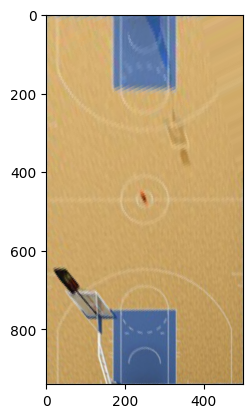

In [180]:
%matplotlib inline
imgplot = plt.imshow(px_estimation)

In [138]:
'''
NOTE: DLT_line_est is identical to DLT_px_est besides the following:
       
       method(): change       -> description
    -----------------------------------------------------------------
    1. __init__: in_l / out_l -> denote the line feature locations 
    2. contstruct_Ai: system  -> constructs constraints using system of equations for line features
'''

class DLT_line_est:
    def __init__(self, in_l, out_l, img):
        assert in_pxs.shape == out_pxs.shape    
        self.in_l = in_l
        self.out_l = out_l
        self.A = np.zeros((8, 9))

        self.H = None
        self.H_inv = None
        
        self.rows = 940
        self.cols = 500

        self.dest = np.asarray([[[j, i] for j in range(self.cols)] for i in range(self.rows)]).astype('float32')
        self.orig = img

        print(self.dest.shape)

        self.new_img = np.zeros((self.rows, self.cols, 3)).astype('uint8')

    def construct_Ai(self, i):
        x, y, w = self.in_l[i]
        u, v, wp = self.out_l[i]

        # Note w & wp = 1
        system = np.array([
            [-u, 0, u * x, -v, 0, v * x, -1, 0, x],
            [0, -u, u * y, 0, -v, v * y, 0, -1, y]
        ])

        print(f'Assembled A{i} for {self.in_l[i]}')
        return system
    
    def assemble_A(self):
        self.Ap = []

        for i in range(len(self.in_l)):
            Ap = self.construct_Ai(i)
            self.A[i*2:(i+1)*2, :] = Ap
        
        print("Assembled A")

    def calc_SVD(self):
        print(self.A.shape)
        
        # Get SVD
        U, S, V = np.linalg.svd(self.A, full_matrices=True)
        homography = V[-1].reshape((3,3))
        
        # Normalize last element to be 1
        return homography / homography[2,2]

    def calc_homography(self):
        '''Homography is correct!'''
        
        self.assemble_A()
        self.H = self.calc_SVD()
        self.H_inv = np.linalg.inv(self.H)

        return self.H, self.H_inv
    
    def apply_homography(self):
        rows, cols, _= self.dest.shape 
        mapping = self.dest.copy()
        print(mapping.shape)

        for i in range(rows):
            for j in range(cols):
                cord = np.append(self.dest[i, j], 1)
                new_cord = (self.H_inv @ cord)
                new_cord = new_cord[:2] / new_cord[2]

                mapping[i, j] = new_cord

        return mapping
    
    def px_bli(self, cord, cord_idx):
        x, y = cord[0], cord[1]
        i, j = int(x), int(y)

        a = x - i
        b = y - j

        rows, cols, _ = self.orig.shape 

        clamp = lambda x, max_val: max(0, min(x, max_val))

        ic = clamp(i, rows - 1)
        jc = clamp(j, cols - 1)
        ic_n = clamp(i + 1, rows -1)
        jc_n = clamp(j + 1, cols -1)
   
        result = (
            self.orig[jc, ic]       * (1-a) * (1-b) +
            self.orig[jc_n, ic]     * a     * (1-b) +
            self.orig[jc_n, ic_n]   * a     * b     + 
            self.orig[jc, ic_n]     * (1-a) * b
        ).astype('uint8')

        self.new_img[cord_idx[0]][cord_idx[1]] = result 

        if(result.min() < 0):
            print(f'Negative result: {result} with {cord_idx[0]} and {cord_idx[1]}')
            print(f'x: {x}, y: {y}, i: {i}, j: {j}, a: {a}, b: {b}')
            print(f'orig[ic, jc]: {self.orig[ic, jc]}, orig[ic_n, jc]: {self.orig[ic_n, jc]},orig[ic_n, jc_n]: {self.orig[ic_n, jc_n]}')
               
    
    def total_bli(self, mapping):
        rows, cols, _ = mapping.shape
        print(mapping.shape)

        for i in range(rows):
            for j in range(cols):
                cord = mapping[i, j]
                self.px_bli(cord, [i, j])
        
        return self.new_img

    def __call__(self): 
        self.calc_homography()
        mapping = self.apply_homography()
        print(mapping[0,0])
        print(mapping[939, 0])
        print(mapping[0, 499])
        print(mapping[939, 499])
        return self.total_bli(mapping)

In [181]:
run = DLT_line_est(in_l, out_l, test_img)
line_feature_image = run()

(940, 500, 2)
Assembled A0 for [ 0.0018132  -0.00539743  1.        ]
Assembled A1 for [ 0.01034173 -0.06969424  1.        ]
Assembled A2 for [-0.00305389 -0.00481741  1.        ]
Assembled A3 for [-0.00224014 -0.00134409  1.        ]
Assembled A
(8, 9)
(940, 500, 2)
[247.14233  51.12339]
[ 23.834497 192.85982 ]
[401.58527  74.05436]
[278.6173  278.33633]
401.58527
278.33633
(940, 500, 2)


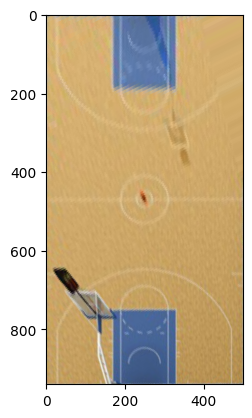

In [182]:
%matplotlib inline
imgplot = plt.imshow(line_feature_image)